# Emoji Prediction

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf


## Load Train and Test CSV file

In [4]:
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')

In [5]:
train_df.head(10)

,Unnamed: 0,TEXT,Label
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,2,Been friends since 7th grade. Look at us now w...,2
3,3,This is what it looks like when someone loves ...,3
4,4,RT @user this white family was invited to a Bl...,3
5,5,"TRACK SEASON 2016, I'M READY FOR YA @ Universi...",4
6,6,Merry Christmas you filthy little animals. Wea...,5
7,7,"Westenders @user #LAZzNation @ Weston, Toronto\n",6
8,8,Maxwell heads home @ Summa Akron City Hospital\n,2
9,9,"Story On Saturday 136 Collins Ave, Miami Beach...",7


In [6]:
test_df.head(10)

,Unnamed: 0,id,TEXT
0,0,0,Thought this was cool...#Repost (get_repost)・・...
1,1,1,Happy 4th! Corte madera parade. #everytownusa ...
2,2,2,Luv. Or at least something close to it. @ Unio...
3,3,3,There's a slice of pie under that whipped crea...
4,5,5,#thankyou for your thank you We adore you both...
5,6,6,the SPECIAL4U Lyric video will be posted on my...
6,7,7,Momma Tanya's In town ! Awesome dinner @user w...
7,8,8,"Thing 1 and Thing 2 @ Huron, Ohio\n"
8,10,10,Bday girl and some random @ Sheraton New York ...
9,11,11,Always fun with my forever wedding date Congra...


## Over-Sampling data

In [8]:
X_train = train_df['TEXT']
Y_train = train_df['Label']

X_test = test_df['TEXT']

In [9]:
from imblearn.over_sampling import RandomOverSampler

# Apply Random Oversampling to balance classes in the training set
os = RandomOverSampler()
X_train_resampled, Y_train_resampled = os.fit_resample(X_train.values.reshape(-1, 1), Y_train)

X_train_resampled = X_train_resampled.flatten()

In [10]:
X_train_resampled.shape

(301820,)

## Tokenization

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_resampled)

In [13]:
print("Text \n",X_train_resampled[:10],'\n')

X_seqs = tokenizer.texts_to_sequences(X_train_resampled)
print("Sequences")
X_seqs[:10]

Text 
 ['Vacation wasted ! #vacation2017 #photobomb #tired #vacationwasted #mcgar30 #miami @ Port of…\n'
 'Oh Wynwood, you’re so funny! : @user #Wynwood #Art #ItWas3AM #Flowers #Vibes @ Wynwood…\n'
 'Been friends since 7th grade. Look at us now we all following our dreams doing what we love and…\n'
 'This is what it looks like when someone loves you unconditionally oh Puppy Brother. #htx…\n'
 "RT @user this white family was invited to a Black barbecue and i've never laughed so hard in my life\n"
 "TRACK SEASON 2016, I'M READY FOR YA @ University of the Incarnate Word\n"
 'Merry Christmas you filthy little animals. Wearing a @user ugly sweater featuring Santa…\n'
 'Westenders @user #LAZzNation @ Weston, Toronto\n'
 'Maxwell heads home @ Summa Akron City Hospital\n'
 'Story On Saturday 136 Collins Ave, Miami Beach, FL 33139 Ladies Contact Me To Join Me In my…\n'] 

Sequences


[[598, 6818, 1, 5120, 2005, 1, 1, 125, 1368, 311],
 [241, 1200, 1184, 27, 855, 3, 1200, 197, 1, 1349, 429, 1],
 [135,
  107,
  502,
  2297,
  2125,
  114,
  16,
  86,
  88,
  28,
  33,
  2479,
  44,
  654,
  432,
  61,
  28,
  19,
  302],
 [14, 15, 61, 23, 431, 51, 52, 553, 516, 11, 1, 241, 1274, 518, 1],
 [1521,
  3,
  14,
  255,
  80,
  36,
  6819,
  4,
  5,
  469,
  7154,
  9,
  270,
  141,
  6524,
  27,
  359,
  8,
  6,
  76],
 [1323, 282, 464, 56, 155, 12, 310, 66, 10, 2, 1, 1568],
 [119, 29, 11, 3000, 64, 1723, 841, 5, 3, 1201, 1860, 1491, 3629],
 [1, 3, 1, 4974, 341],
 [1, 3885, 94, 4568, 4435, 59, 1329],
 [1015,
  20,
  216,
  1,
  4368,
  1350,
  125,
  34,
  456,
  1,
  358,
  2202,
  21,
  4,
  729,
  21,
  8,
  664]]

In [14]:
idx2words = tokenizer.index_word

print("Word Mappings\n")
for i in range(1,10):
    print("Index: ",i, "---->",idx2words[i])

Word Mappings

Index:  1 ----> <OOV>
Index:  2 ----> the
Index:  3 ----> user
Index:  4 ----> to
Index:  5 ----> a
Index:  6 ----> my
Index:  7 ----> i
Index:  8 ----> in
Index:  9 ----> and


In [15]:
vocab_size = len(tokenizer.index_word)
print("Vocabulary size: :", len(tokenizer.index_word))

Vocabulary size: : 85531


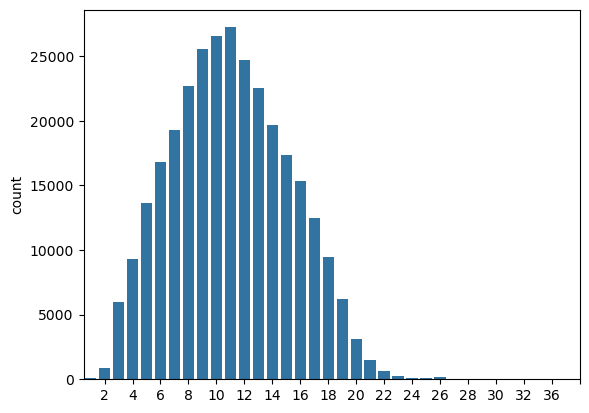

In [16]:
lens = [len(seq) for seq in X_seqs]
sns.countplot(x=lens)
plt.xticks(ticks=range(1, max(lens) + 1, 2))
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
# Convert texts to sequences of numbers
train_sequences = tokenizer.texts_to_sequences(X_train_resampled)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure they all have the same length
max_length = 100  # You can adjust this based on your dataset
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [18]:
# Check the unique values in Y_train_resampled to identify the label range
unique_labels = set(Y_train_resampled)
print("Unique labels in Y_train_resampled:", unique_labels)

# Find the maximum label value in Y_train_resampled
num_classes = max(Y_train_resampled) + 1  # Ensure num_classes equals the highest label + 1

# Convert labels to categorical (for emoji classification)
train_labels = tf.keras.utils.to_categorical(Y_train_resampled, num_classes=num_classes)

# Check if the issue is resolved
print("Shape of train_labels:", train_labels.shape)

Unique labels in Y_train_resampled: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Shape of train_labels: (301820, 20)


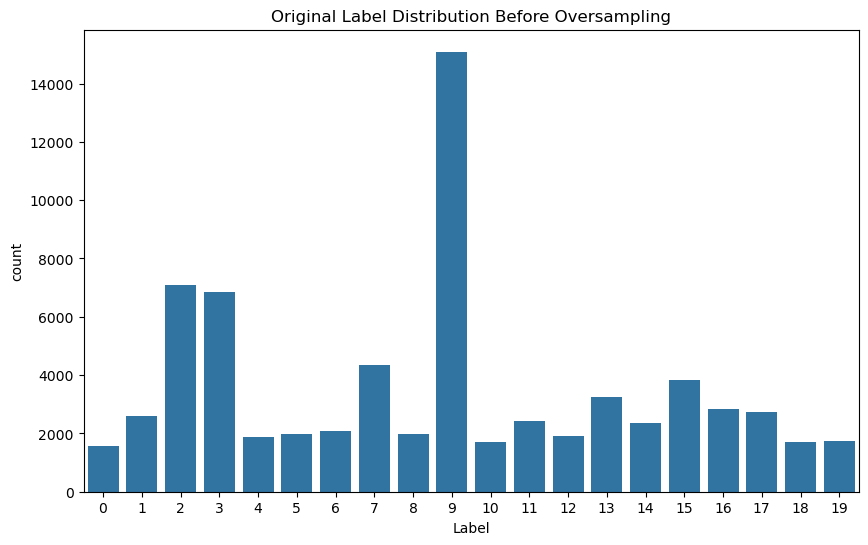

In [19]:
# Plot original label distribution before oversampling
plt.figure(figsize=(10, 6))
sns.countplot(x=Y_train)
plt.title('Original Label Distribution Before Oversampling')
plt.show()


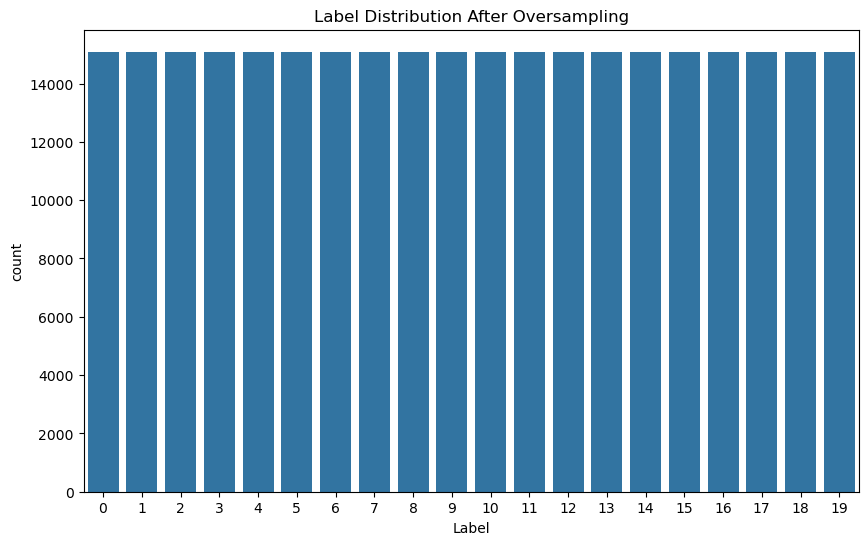

In [20]:
# Plot label distribution after oversampling
plt.figure(figsize=(10, 6))
sns.countplot(x=Y_train_resampled)
plt.title('Label Distribution After Oversampling')
plt.show()

In [21]:
from sklearn.model_selection import train_test_split

X_train_final, X_val_final, Y_train_final, Y_val_final = train_test_split(
    X_train_padded, train_labels, test_size=0.2, random_state=42
)

# Check the shape of the splits
print("Training data shape:", X_train_final.shape)
print("Validation data shape:", X_val_final.shape)
print("Training labels shape:", Y_train_final.shape)
print("Validation labels shape:", Y_val_final.shape)

Training data shape: (241456, 100)
Validation data shape: (60364, 100)
Training labels shape: (241456, 20)
Validation labels shape: (60364, 20)


## Deep Learning Model using LSTMs


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),  # Adjust embedding layer dimensions
    LSTM(64, return_sequences=False),  # LSTM layer with 64 units
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(20, activation='softmax')  # Output layer for 20 emoji classes
])
# Build the model with input shape
lstm_model.build(input_shape=(None, 100))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
lstm_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,764 (2.58 MB)

 Trainable params: 675,764 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the LSTM model
history_lstm = lstm_model.fit(
    X_train_final, Y_train_final,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_final, Y_val_final)
)

# Evaluate LSTM model
lstm_model.evaluate(X_test_padded, Y_test_final)

Epoch 1/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 175s 23ms/step - accuracy: 0.0499 - loss: 2.9959 - val_accuracy: 0.0504 - val_loss: 2.9961
Epoch 2/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 179s 24ms/step - accuracy: 0.0479 - loss: 2.9959 - val_accuracy: 0.0482 - val_loss: 2.9959
Epoch 3/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 174s 23ms/step - accuracy: 0.0486 - loss: 2.9960 - val_accuracy: 0.0499 - val_loss: 2.9961
Epoch 4/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 175s 23ms/step - accuracy: 0.0498 - loss: 2.9959 - val_accuracy: 0.0502 - val_loss: 2.9962
Epoch 5/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 179s 24ms/step - accuracy: 0.0489 - loss: 2.9960 - val_accuracy: 0.0494 - val_loss: 2.9959
Epoch 6/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 183s 24ms/step - accuracy: 0.0485 - loss: 2.9960 - val_accuracy: 0.0507 - val_loss: 2.9959
Epoch 7/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 186s 25ms/step - accuracy: 0.0500 - loss: 2.9959 - val_accuracy: 0.0498 - val_loss: 2.9959
Epoch 8/10
7546/7546 ━━━━━━━━━━━━━━━━━━━━ 177s 23ms/step - accuracy: 

NameError: name 'Y_test_final' is not defined

In [ ]:
# Plot LSTM model performance
loss_lstm = pd.DataFrame(history_lstm.history)
plt.plot(loss_lstm['loss'], label='Training Loss')
plt.plot(loss_lstm['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Deep Learning Model using Bidirectional LSTMs


In [ ]:
from tensorflow.keras.layers import Bidirectional

# Define the Bidirectional LSTM model
bidirectional_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),  # Adjust embedding layer dimensions
    Bidirectional(LSTM(64, return_sequences=False)),  # Bidirectional LSTM layer
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(20, activation='softmax')  # Output layer for 20 emoji classes
])
# Build the model with input shape
bi_lstm_model.build(input_shape=(None, 100))

# Compile the model
bidirectional_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
bidirectional_model.summary()


In [ ]:
# Train the Bidirectional LSTM model
history_bidir = bidirectional_model.fit(
    X_train_final, Y_train_final,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_final, Y_val_final)
)

# Evaluate Bidirectional LSTM model
bidirectional_model.evaluate(X_test_padded, Y_test_final)

In [ ]:
# Plot Bidirectional LSTM model performance
loss_bidir = pd.DataFrame(history_bidir.history)
plt.plot(loss_bidir['loss'], label='Training Loss')
plt.plot(loss_bidir['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()